In [1]:
# Generative Adversarial Networks on MNIST data using TF-GAN library using tensorflow V2

In [2]:
# Install tensorflow_gan TF-GAN library
!pip install tensorflow-gan

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.1/367.1 kB 3.1 MB/s eta 0:00:00


In [3]:
import tensorflow as tf
import tensorflow.compat.v1 as tfv1
import tensorflow_gan as tfgan
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline


In [4]:

# MNIST dataset
"""
The MNIST dataset contains tens of thousands of images of handwritten digits.
Use these images to train a GAN to generate fake images of handwritten digits.
"""

def input_fun(mode, params):
  assert 'batch_size' in params
  assert 'noise_dims' in params
  bs = params['batch_size']
  nd = params['noise_dims']
  split = 'train' if mode == tfv1.estimator.ModeKeys.TRAIN else 'test'
  shuffle = (mode == tfv1.estimator.ModeKeys.TRAIN)
  just_noise = (mode == tfv1.estimator.ModeKeys.PREDICT)

  noise_ds = (tf.data.Dataset.from_tensors(0).repeat()
              .map(lambda _: tf.random.normal([bs, nd])))

  if just_noise:
    return noise_ds

  normalization_layer = tf.keras.layers.Rescaling(scale=1./127.5, offset=-1)

  images_ds = (tfds.load('mnist:3.*.*', split=split)
               .map(lambda x: normalization_layer(x['image']))
               .cache()
               .repeat())
  if shuffle:
    images_ds = images_ds.shuffle(
        buffer_size=10000, reshuffle_each_iteration=True)
  images_ds = (images_ds.batch(bs, drop_remainder=True)
               .prefetch(tf.data.experimental.AUTOTUNE))

  return tf.data.Dataset.zip((noise_ds, images_ds))



Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


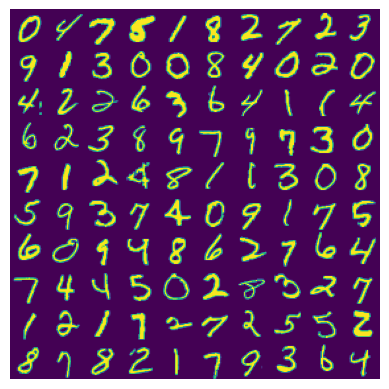

In [5]:
params = {'batch_size': 100, 'noise_dims':64}
with tfv1.Graph().as_default():
  dataset = input_fun(tfv1.estimator.ModeKeys.TRAIN, params)
  numpy_imgs = next(iter(tfds.as_numpy(dataset)))[1]
  numpy_noise = next(iter(tfds.as_numpy(dataset)))[0]

img_grid = tfgan.eval.python_image_grid(numpy_imgs, grid_shape=(10, 10))
plt.axis('off')
plt.imshow(np.squeeze(img_grid))
plt.show()


In [6]:
numpy_imgs.shape, numpy_noise.shape

((100, 28, 28, 1), (100, 64))

In [7]:
# Neural Network Architecture for GAN
# GAN composed of Generator network and Discriminator network
# Both networks are stacks of convolutional and de-convolutional layers

# # tensorflow version V2 model layers

def common_dense_layer(units, l2_weights):
  return tf.keras.layers.Dense(units, activation=None,
                               kernel_regularizer=tf.keras.regularizers.L2(l2=l2_weights),
                               bias_regularizer=tf.keras.regularizers.L2(l2=l2_weights))


def common_conv2d_layer(filters, kernel_size, stride, l2_weights):
  return tf.keras.layers.Conv2D(filters=filters,
                                kernel_size=kernel_size,
                                strides=(stride, stride),
                                padding='same',
                                kernel_regularizer=tf.keras.regularizers.L2(l2=l2_weights),
                                bias_regularizer=tf.keras.regularizers.L2(l2=l2_weights)
                                )


def common_conv2d_transpose_layer(filters, kernel_size, stride, l2_weights):
  return tf.keras.layers.Conv2DTranspose(filters,
                                         kernel_size,
                                         strides=(stride, stride),
                                         activation='relu',
                                         padding='same',
                                         kernel_regularizer=tf.keras.regularizers.L2(l2=l2_weights),
                                         bias_regularizer=tf.keras.regularizers.L2(l2=l2_weights)
                                         )


In [8]:
# tensorflow version v1 model layers
def _dense(inputs, units, l2_weight):
  return tfv1.layers.dense(
      inputs, units, None,
      kernel_initializer=tfv1.keras.initializers.glorot_uniform,
      kernel_regularizer=tfv1.keras.regularizers.l2(l=l2_weight),
      bias_regularizer=tfv1.keras.regularizers.l2(l=l2_weight))

def _batch_norm(inputs, is_training):
  return tfv1.layers.batch_normalization(
      inputs, momentum=0.999, epsilon=0.001, training=is_training)

def _deconv2d(inputs, filters, kernel_size, stride, l2_weight):
  return tfv1.layers.conv2d_transpose(
      inputs, filters, [kernel_size, kernel_size], strides=[stride, stride],
      activation=tfv1.nn.relu, padding='same',
      kernel_initializer=tfv1.keras.initializers.glorot_uniform,
      kernel_regularizer=tfv1.keras.regularizers.l2(l=l2_weight),
      bias_regularizer=tfv1.keras.regularizers.l2(l=l2_weight))

def _conv2d(inputs, filters, kernel_size, stride, l2_weight):
  return tfv1.layers.conv2d(
      inputs, filters, [kernel_size, kernel_size], strides=[stride, stride],
      activation=None, padding='same',
      kernel_initializer=tfv1.keras.initializers.glorot_uniform,
      kernel_regularizer=tfv1.keras.regularizers.l2(l=l2_weight),
      bias_regularizer=tfv1.keras.regularizers.l2(l=l2_weight))

In [9]:
# Generator Network
# This network takes random noise (z) as input and tries to generate data (x) that
# resembles real MNIST image samples from a certain distribution

def generator_net(noise_input, weight_decay=2.5e-5):

  input = tf.keras.Input(64)

  g_net = common_dense_layer(512, weight_decay)(input)  #output = 512 dimentional vector
  g_net = tf.keras.layers.BatchNormalization()(g_net) #output = 512
  g_net = tf.keras.layers.ReLU()(g_net)  # output = 512

  g_net = common_dense_layer(7 * 7 * 128, weight_decay)(g_net) # output = 6272
  g_net = tf.keras.layers.BatchNormalization()(g_net)  # output = 6272
  g_net = tf.keras.layers.ReLU()(g_net)  # output = 6272

  g_net = tf.reshape(g_net, [-1, 7, 7, 128])  #output= 7x7x128
  g_net = common_conv2d_transpose_layer(64, 4, 2, weight_decay)(g_net)  # output = 14x14x64
  g_net = common_conv2d_transpose_layer(32, 4, 2, weight_decay)(g_net)   # output = 28x28x32

  # Make sure that generator output is in the same range as `inputs` i.e [-1, 1].
  g_net = common_conv2d_layer(1, 4, 1, 0.0)(g_net)   # 28x28x1
  g_net = tf.tanh(g_net)               # logits for each pixel position in [-1, 1]
                                       # output = 28x28x1

  model = tf.keras.Model(inputs=input, outputs=g_net)
  model = model(noise_input)

  return model


In [10]:
# Discriminator Network
# The discriminator is trained to become better at distinguishing between real
# and fake data. It learns to improve its ability to correctly classify the data,
# whether it's from the training set or generated by the generator.

def discriminator_net(img, unused_conditioning, mode, weight_decay=2.5e-5):
  del unused_conditioning
  is_training = (mode == tf.estimator.ModeKeys.TRAIN)
  input_shape = (28, 28, 1)

  net = _conv2d(img, 64, 4, 2, weight_decay)  # output = 14x14x64
  net = tf.keras.layers.LeakyReLU(alpha=0.01)(net)

  net = _conv2d(net, 32, 4, 2, weight_decay)  # output = 28x28x32
  net = tf.keras.layers.LeakyReLU(alpha=0.01)(net)

  net = tf.keras.layers.Flatten()(net)  # output = 25088

  net = _dense(net, 512, weight_decay) # output = 512
  net = _batch_norm(net, is_training)
  net = tf.keras.layers.LeakyReLU(alpha=0.01)(net)

  net = _dense(net, 1, weight_decay) # # output = 1

  return net

In [11]:
# Evaluating metrics
from tensorflow_gan.examples.mnist import util as eval_util

def get_eval_metric_ops_fn(gan_model):
  # outputs from discriminator
  real_data_logits = tf.reduce_mean(gan_model.discriminator_real_outputs)

  # outputs from generator
  gen_data_logits = tf.reduce_mean(gan_model.discriminator_gen_outputs)

  real_mnist_score = eval_util.mnist_score(gan_model.real_data) # Inception Score

  generated_mnist_score = eval_util.mnist_score(gan_model.generated_data) # Inception Score

  # Frechet Inception Distance
  # Frechet Inception Distance measures how close the generated image distribution
  # is to the real image distribution..
  frechet_distance = eval_util.mnist_frechet_distance(
      gan_model.real_data, gan_model.generated_data)

  return {
      'real_data_logits': tfv1.metrics.mean(real_data_logits),
      'gen_data_logits': tfv1.metrics.mean(gen_data_logits),
      'real_mnist_score': tfv1.metrics.mean(real_mnist_score),
      'mnist_score': tfv1.metrics.mean(generated_mnist_score),
      'frechet_distance': tfv1.metrics.mean(frechet_distance),
  }

In [12]:
# GANEstimator
# TensorFlow's Estimator API that makes it easy to train models. TF-GAN offers
# GANEstimator, an Estimator for training GANs.

"""
The GANEstimator assembles and manages the pieces of the whole GAN model.
The GANEstimator constructor takes the following compoonents for both the
generator and discriminator:

1. Network builder functions: generator or discriminator network architecture
2. Loss functions: Use the wasserstein loss for both network training.
3. Optimizers: Use tf.train.AdamOptimizer for both generator and discriminator training.
"""

# Hyperparameter
train_batch_size = 32
noise_dimensions = 64
generator_lr = 0.001
discriminator_lr = 0.0002

# optimizer for generator
def generator_opt():
  gstep = tfv1.train.get_or_create_global_step()
  base_lr = generator_lr

  # Halve the learning rate at 1000 steps.
  lr = tfv1.cond(gstep < 1000, lambda: base_lr, lambda: base_lr / 2.0)
  return tfv1.train.AdamOptimizer(lr, 0.5)


#gan_estimator = tfgan.estimator.gan_estimator.GANEstimator()

gan_estimator = tfgan.estimator.GANEstimator(
    generator_fn= generator_net,
    discriminator_fn= discriminator_net,
    generator_loss_fn=tfgan.losses.wasserstein_generator_loss, # g loss
    discriminator_loss_fn=tfgan.losses.wasserstein_discriminator_loss, # d loss
    params={'batch_size': train_batch_size, 'noise_dims': noise_dimensions},
    generator_optimizer=generator_opt,
    discriminator_optimizer=tfv1.train.AdamOptimizer(discriminator_lr, 0.5),
    get_eval_metric_ops_fn=get_eval_metric_ops_fn)

Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.


In [13]:
# Training phase
# The GANEstimator's train() method initiates GAN training, including the alternating
# generator and discriminator training phases.

# Disable noisy output.
tfv1.autograph.set_verbosity(0, False)

import time
steps_per_eval = 50
max_train_steps = 5000
batches_for_eval_metrics = 100

# Used to track metrics.
steps = []
real_logits, fake_logits = [], []
real_mnist_scores, mnist_scores, frechet_distances = [], [], []

Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
Instructions for updating:
Colocations handled automatically by placer.
<ipython-input-8-5ddc8a56ccac>:22: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  return tfv1.layers.conv2d(
<ipython-input-8-5ddc8a56ccac>:3: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tfv1.layers.dense(
<ipython-input-8-5ddc8a56ccac>:10: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation

Time since start: 0.45 min
Trained from step 0 to 50 in 1.83 steps / sec


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.map_fn(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(fn, elems))
Instructions for updating:
Use tf.keras instead.


Average discriminator output on Real: 0.01  Fake: 0.00
Inception Score: 1.82 / 8.35  Frechet Distance: 263.87


Instructions for updating:
Use tf.keras instead.


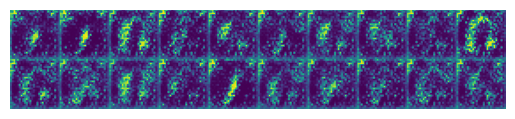

Instructions for updating:
Use standard file utilities to get mtimes.


Time since start: 0.76 min
Trained from step 50 to 100 in 9.02 steps / sec
Average discriminator output on Real: 0.03  Fake: -0.01
Inception Score: 3.20 / 8.35  Frechet Distance: 161.32


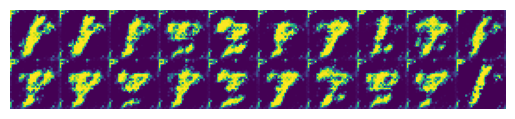

Time since start: 0.97 min
Trained from step 100 to 150 in 9.30 steps / sec


Exception ignored in: <generator object Estimator.predict at 0x7c618df1bca0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 618, in predict
  File "/usr/lib/python3.10/contextlib.py", line 153, in __exit__
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 5931, in get_controller
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/context.py", line 272, in pop
IndexError: pop from empty list


Average discriminator output on Real: 0.03  Fake: -0.01
Inception Score: 2.95 / 8.35  Frechet Distance: 201.63


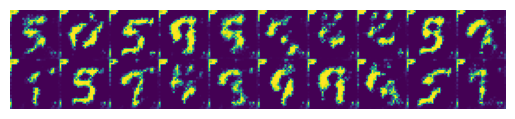

Time since start: 1.19 min
Trained from step 150 to 200 in 8.59 steps / sec


Exception ignored in: <generator object Estimator.predict at 0x7c61682a8970>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 618, in predict
  File "/usr/lib/python3.10/contextlib.py", line 153, in __exit__
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 5931, in get_controller
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/context.py", line 272, in pop
IndexError: pop from empty list


Average discriminator output on Real: -0.03  Fake: -0.06
Inception Score: 4.72 / 8.35  Frechet Distance: 95.19


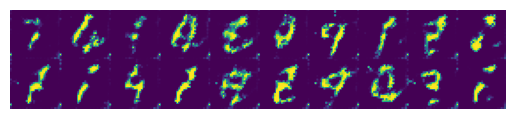

Instructions for updating:
Use standard file APIs to delete files with this prefix.


Time since start: 1.38 min
Trained from step 200 to 250 in 9.26 steps / sec


Exception ignored in: <generator object Estimator.predict at 0x7c61681dba00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 618, in predict
  File "/usr/lib/python3.10/contextlib.py", line 153, in __exit__
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 5931, in get_controller
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/context.py", line 272, in pop
IndexError: pop from empty list


Average discriminator output on Real: 0.10  Fake: 0.04
Inception Score: 3.32 / 8.35  Frechet Distance: 174.40


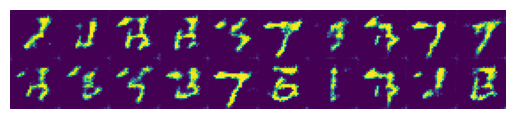

Time since start: 1.57 min
Trained from step 250 to 300 in 9.40 steps / sec


Exception ignored in: <generator object Estimator.predict at 0x7c61a014c190>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 618, in predict
  File "/usr/lib/python3.10/contextlib.py", line 153, in __exit__
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 5931, in get_controller
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/context.py", line 272, in pop
IndexError: pop from empty list


Average discriminator output on Real: 0.08  Fake: 0.03
Inception Score: 4.43 / 8.35  Frechet Distance: 127.98


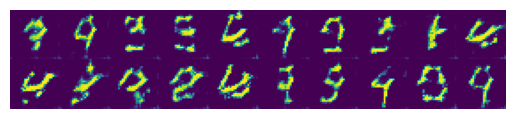

Time since start: 1.83 min
Trained from step 300 to 350 in 5.94 steps / sec


Exception ignored in: <generator object Estimator.predict at 0x7c616583e490>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 618, in predict
  File "/usr/lib/python3.10/contextlib.py", line 153, in __exit__
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 5931, in get_controller
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/context.py", line 272, in pop
IndexError: pop from empty list


Average discriminator output on Real: 0.06  Fake: 0.04
Inception Score: 4.77 / 8.35  Frechet Distance: 105.09


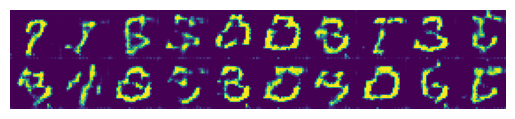

Time since start: 2.03 min
Trained from step 350 to 400 in 8.60 steps / sec


Exception ignored in: <generator object Estimator.predict at 0x7c6108f6a180>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 618, in predict
  File "/usr/lib/python3.10/contextlib.py", line 153, in __exit__
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 5931, in get_controller
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/context.py", line 272, in pop
IndexError: pop from empty list


Average discriminator output on Real: 0.08  Fake: 0.05
Inception Score: 4.88 / 8.35  Frechet Distance: 106.52


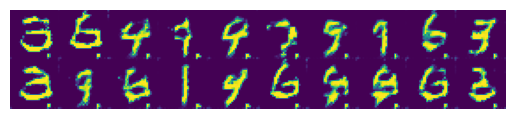

Time since start: 2.22 min
Trained from step 400 to 450 in 9.46 steps / sec


Exception ignored in: <generator object Estimator.predict at 0x7c6164454900>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 618, in predict
  File "/usr/lib/python3.10/contextlib.py", line 153, in __exit__
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 5931, in get_controller
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/context.py", line 272, in pop
IndexError: pop from empty list


Average discriminator output on Real: 0.06  Fake: 0.03
Inception Score: 5.84 / 8.35  Frechet Distance: 76.26


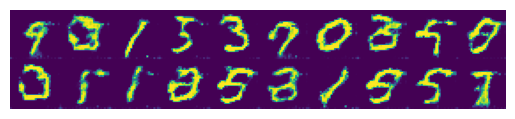

Time since start: 2.43 min
Trained from step 450 to 500 in 8.53 steps / sec


Exception ignored in: <generator object Estimator.predict at 0x7c61651417e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 618, in predict
  File "/usr/lib/python3.10/contextlib.py", line 153, in __exit__
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 5931, in get_controller
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/context.py", line 272, in pop
IndexError: pop from empty list


Average discriminator output on Real: 0.06  Fake: 0.08
Inception Score: 4.85 / 8.35  Frechet Distance: 100.04


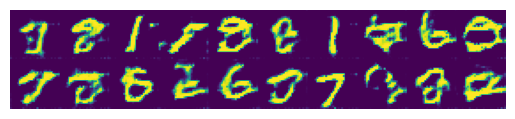

Time since start: 2.63 min
Trained from step 500 to 550 in 9.17 steps / sec


Exception ignored in: <generator object Estimator.predict at 0x7c61092e1460>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 618, in predict
  File "/usr/lib/python3.10/contextlib.py", line 153, in __exit__
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 5931, in get_controller
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/context.py", line 272, in pop
IndexError: pop from empty list


Average discriminator output on Real: 0.15  Fake: 0.15
Inception Score: 5.22 / 8.35  Frechet Distance: 116.92


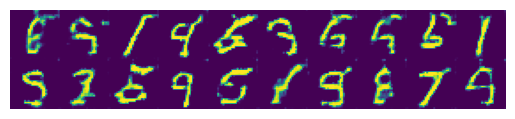

Time since start: 2.82 min
Trained from step 550 to 600 in 9.30 steps / sec


Exception ignored in: <generator object Estimator.predict at 0x7c6109152f10>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 618, in predict
  File "/usr/lib/python3.10/contextlib.py", line 153, in __exit__
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 5931, in get_controller
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/context.py", line 272, in pop
IndexError: pop from empty list


Average discriminator output on Real: -0.02  Fake: -0.08
Inception Score: 5.32 / 8.35  Frechet Distance: 105.28


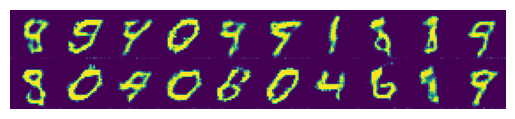

Time since start: 3.06 min
Trained from step 600 to 650 in 7.40 steps / sec


Exception ignored in: <generator object Estimator.predict at 0x7c610885c350>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 618, in predict
  File "/usr/lib/python3.10/contextlib.py", line 153, in __exit__
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 5931, in get_controller
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/context.py", line 272, in pop
IndexError: pop from empty list


Average discriminator output on Real: -0.46  Fake: -0.60
Inception Score: 5.48 / 8.35  Frechet Distance: 92.70


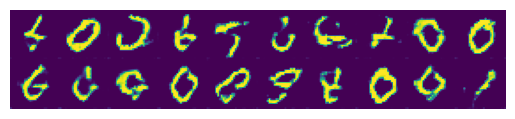

Time since start: 3.29 min
Trained from step 650 to 700 in 7.22 steps / sec


Exception ignored in: <generator object Estimator.predict at 0x7c61031da260>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 618, in predict
  File "/usr/lib/python3.10/contextlib.py", line 153, in __exit__
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 5931, in get_controller
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/context.py", line 272, in pop
IndexError: pop from empty list


Average discriminator output on Real: -0.91  Fake: -1.13
Inception Score: 6.26 / 8.35  Frechet Distance: 80.28


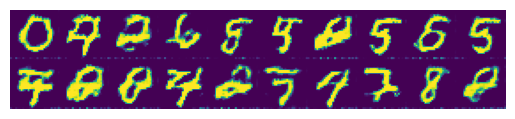

Time since start: 3.48 min
Trained from step 700 to 750 in 8.30 steps / sec


Exception ignored in: <generator object Estimator.predict at 0x7c6101c4c200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 618, in predict
  File "/usr/lib/python3.10/contextlib.py", line 153, in __exit__
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 5931, in get_controller
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/context.py", line 272, in pop
IndexError: pop from empty list


Average discriminator output on Real: -1.93  Fake: -2.09
Inception Score: 5.74 / 8.35  Frechet Distance: 83.36


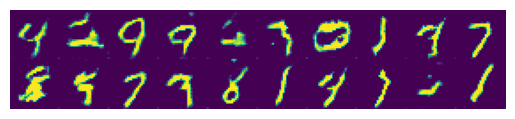

Time since start: 3.68 min
Trained from step 750 to 800 in 8.60 steps / sec


Exception ignored in: <generator object Estimator.predict at 0x7c61091537d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 618, in predict
  File "/usr/lib/python3.10/contextlib.py", line 153, in __exit__
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 5931, in get_controller
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/context.py", line 272, in pop
IndexError: pop from empty list


Average discriminator output on Real: -3.75  Fake: -3.93
Inception Score: 6.33 / 8.35  Frechet Distance: 65.23


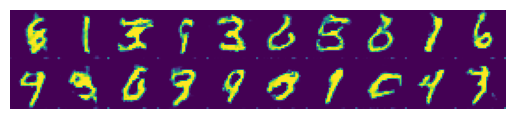

Time since start: 3.86 min
Trained from step 800 to 850 in 9.44 steps / sec


Exception ignored in: <generator object Estimator.predict at 0x7c60fc40bf40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 618, in predict
  File "/usr/lib/python3.10/contextlib.py", line 153, in __exit__
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 5931, in get_controller
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/context.py", line 272, in pop
IndexError: pop from empty list


Average discriminator output on Real: -6.31  Fake: -6.54
Inception Score: 5.76 / 8.35  Frechet Distance: 87.75


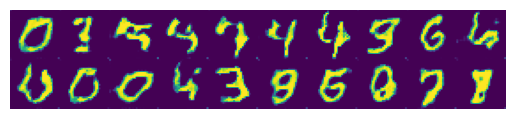

Time since start: 4.08 min
Trained from step 850 to 900 in 8.62 steps / sec


Exception ignored in: <generator object Estimator.predict at 0x7c610389eb90>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 618, in predict
  File "/usr/lib/python3.10/contextlib.py", line 153, in __exit__
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 5931, in get_controller
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/context.py", line 272, in pop
IndexError: pop from empty list


Average discriminator output on Real: -8.65  Fake: -8.56
Inception Score: 6.33 / 8.35  Frechet Distance: 71.61


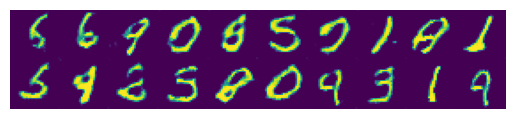

Time since start: 4.32 min
Trained from step 900 to 950 in 7.82 steps / sec


Exception ignored in: <generator object Estimator.predict at 0x7c61025ebd10>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 618, in predict
  File "/usr/lib/python3.10/contextlib.py", line 153, in __exit__
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 5931, in get_controller
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/context.py", line 272, in pop
IndexError: pop from empty list


Average discriminator output on Real: -9.65  Fake: -9.55
Inception Score: 6.42 / 8.35  Frechet Distance: 73.37


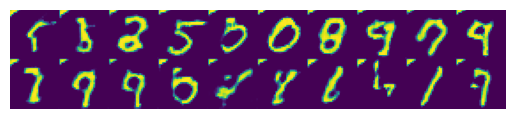

Time since start: 4.55 min
Trained from step 950 to 1000 in 5.97 steps / sec


Exception ignored in: <generator object Estimator.predict at 0x7c6100dc3ed0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 618, in predict
  File "/usr/lib/python3.10/contextlib.py", line 153, in __exit__
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 5931, in get_controller
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/context.py", line 272, in pop
IndexError: pop from empty list


Average discriminator output on Real: -10.05  Fake: -9.72
Inception Score: 6.32 / 8.35  Frechet Distance: 67.71


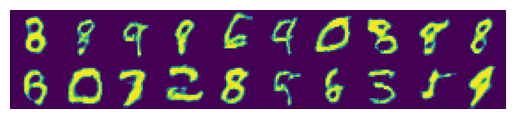

Time since start: 4.75 min
Trained from step 1000 to 1050 in 7.90 steps / sec


Exception ignored in: <generator object Estimator.predict at 0x7c60fc4299a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 618, in predict
  File "/usr/lib/python3.10/contextlib.py", line 153, in __exit__
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 5931, in get_controller
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/context.py", line 272, in pop
IndexError: pop from empty list


Average discriminator output on Real: -9.28  Fake: -9.14
Inception Score: 6.75 / 8.35  Frechet Distance: 62.82


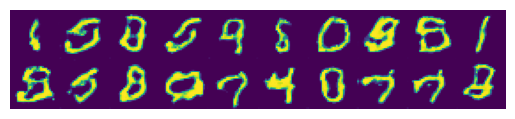

Time since start: 4.95 min
Trained from step 1050 to 1100 in 7.97 steps / sec


Exception ignored in: <generator object Estimator.predict at 0x7c61014f3d80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 618, in predict
  File "/usr/lib/python3.10/contextlib.py", line 153, in __exit__
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 5931, in get_controller
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/context.py", line 272, in pop
IndexError: pop from empty list


Average discriminator output on Real: -8.96  Fake: -8.51
Inception Score: 6.85 / 8.35  Frechet Distance: 58.47


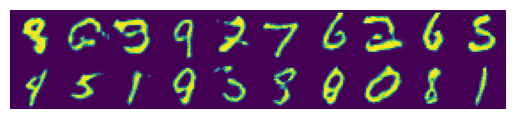

Time since start: 5.17 min
Trained from step 1100 to 1150 in 7.84 steps / sec


Exception ignored in: <generator object Estimator.predict at 0x7c60fcf936f0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 618, in predict
  File "/usr/lib/python3.10/contextlib.py", line 153, in __exit__
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 5931, in get_controller
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/context.py", line 272, in pop
IndexError: pop from empty list


Average discriminator output on Real: -7.82  Fake: -7.47
Inception Score: 6.83 / 8.35  Frechet Distance: 61.87


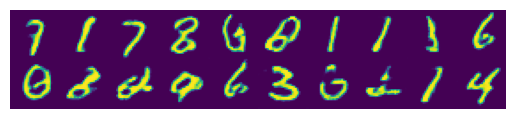

Time since start: 5.39 min
Trained from step 1150 to 1200 in 7.06 steps / sec


Exception ignored in: <generator object Estimator.predict at 0x7c60fc75df50>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 618, in predict
  File "/usr/lib/python3.10/contextlib.py", line 153, in __exit__
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 5931, in get_controller
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/context.py", line 272, in pop
IndexError: pop from empty list


Average discriminator output on Real: -7.19  Fake: -7.38
Inception Score: 6.91 / 8.35  Frechet Distance: 60.50


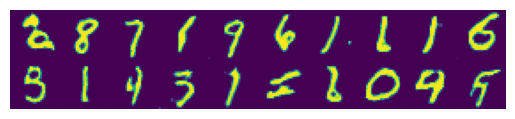

Time since start: 5.59 min
Trained from step 1200 to 1250 in 7.94 steps / sec


Exception ignored in: <generator object Estimator.predict at 0x7c60f21abdf0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 618, in predict
  File "/usr/lib/python3.10/contextlib.py", line 153, in __exit__
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 5931, in get_controller
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/context.py", line 272, in pop
IndexError: pop from empty list


Average discriminator output on Real: -6.16  Fake: -6.07
Inception Score: 6.70 / 8.35  Frechet Distance: 69.74


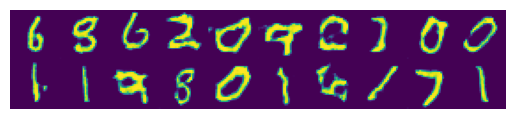

Time since start: 5.79 min
Trained from step 1250 to 1300 in 8.04 steps / sec


Exception ignored in: <generator object Estimator.predict at 0x7c60dc59fe60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 618, in predict
  File "/usr/lib/python3.10/contextlib.py", line 153, in __exit__
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 5931, in get_controller
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/context.py", line 272, in pop
IndexError: pop from empty list


Average discriminator output on Real: -4.15  Fake: -4.33
Inception Score: 7.03 / 8.35  Frechet Distance: 58.08


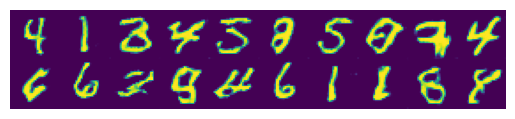

Time since start: 5.98 min
Trained from step 1300 to 1350 in 7.86 steps / sec


Exception ignored in: <generator object Estimator.predict at 0x7c60f26a09e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 618, in predict
  File "/usr/lib/python3.10/contextlib.py", line 153, in __exit__
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 5931, in get_controller
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/context.py", line 272, in pop
IndexError: pop from empty list


Average discriminator output on Real: -3.32  Fake: -3.54
Inception Score: 7.04 / 8.35  Frechet Distance: 64.79


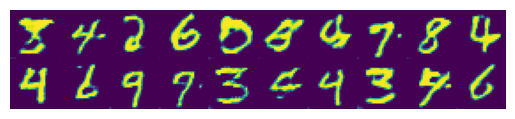

Time since start: 6.22 min
Trained from step 1350 to 1400 in 5.99 steps / sec


Exception ignored in: <generator object Estimator.predict at 0x7c60ddc0daf0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 618, in predict
  File "/usr/lib/python3.10/contextlib.py", line 153, in __exit__
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 5931, in get_controller
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/context.py", line 272, in pop
IndexError: pop from empty list


Average discriminator output on Real: -2.94  Fake: -3.08
Inception Score: 6.93 / 8.35  Frechet Distance: 63.10


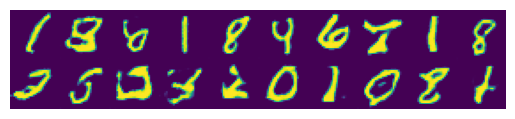

Time since start: 6.43 min
Trained from step 1400 to 1450 in 7.82 steps / sec


Exception ignored in: <generator object Estimator.predict at 0x7c60dd1ed000>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 618, in predict
  File "/usr/lib/python3.10/contextlib.py", line 153, in __exit__
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 5931, in get_controller
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/context.py", line 272, in pop
IndexError: pop from empty list


Average discriminator output on Real: -1.25  Fake: -1.16
Inception Score: 7.07 / 8.35  Frechet Distance: 61.36


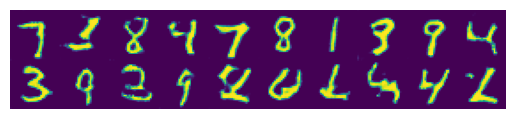

Time since start: 6.66 min
Trained from step 1450 to 1500 in 7.03 steps / sec


Exception ignored in: <generator object Estimator.predict at 0x7c60d9a9e3b0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 618, in predict
  File "/usr/lib/python3.10/contextlib.py", line 153, in __exit__
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 5931, in get_controller
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/context.py", line 272, in pop
IndexError: pop from empty list


Average discriminator output on Real: -1.12  Fake: -1.30
Inception Score: 6.86 / 8.35  Frechet Distance: 61.61


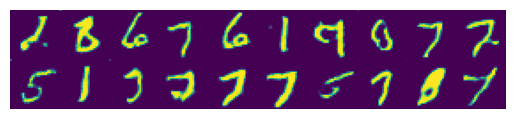

Time since start: 6.88 min
Trained from step 1500 to 1550 in 6.94 steps / sec


Exception ignored in: <generator object Estimator.predict at 0x7c60dd887bc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 618, in predict
  File "/usr/lib/python3.10/contextlib.py", line 153, in __exit__
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 5931, in get_controller
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/context.py", line 272, in pop
IndexError: pop from empty list


Average discriminator output on Real: 0.34  Fake: 0.48
Inception Score: 7.09 / 8.35  Frechet Distance: 60.89


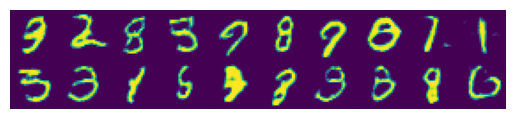

Time since start: 7.07 min
Trained from step 1550 to 1600 in 8.08 steps / sec


Exception ignored in: <generator object Estimator.predict at 0x7c60d9851b60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 618, in predict
  File "/usr/lib/python3.10/contextlib.py", line 153, in __exit__
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 5931, in get_controller
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/context.py", line 272, in pop
IndexError: pop from empty list


Average discriminator output on Real: 1.39  Fake: 1.32
Inception Score: 7.12 / 8.35  Frechet Distance: 64.27


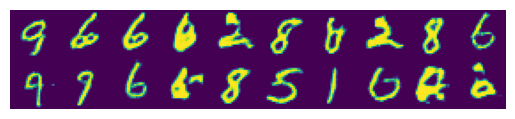

Time since start: 7.27 min
Trained from step 1600 to 1650 in 8.10 steps / sec


Exception ignored in: <generator object Estimator.predict at 0x7c60d8a85620>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 618, in predict
  File "/usr/lib/python3.10/contextlib.py", line 153, in __exit__
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 5931, in get_controller
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/context.py", line 272, in pop
IndexError: pop from empty list


Average discriminator output on Real: 2.13  Fake: 2.01
Inception Score: 7.10 / 8.35  Frechet Distance: 60.64


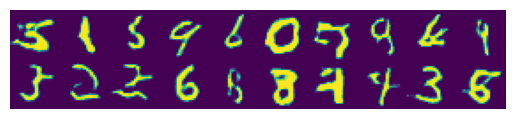

Time since start: 7.46 min
Trained from step 1650 to 1700 in 8.01 steps / sec


Exception ignored in: <generator object Estimator.predict at 0x7c60d909fed0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 618, in predict
  File "/usr/lib/python3.10/contextlib.py", line 153, in __exit__
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 5931, in get_controller
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/context.py", line 272, in pop
IndexError: pop from empty list


Average discriminator output on Real: 2.04  Fake: 1.91
Inception Score: 7.28 / 8.35  Frechet Distance: 61.81


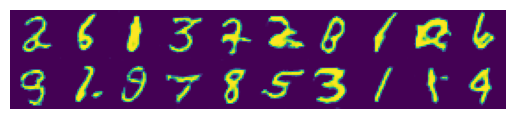

Time since start: 7.66 min
Trained from step 1700 to 1750 in 8.16 steps / sec
Average discriminator output on Real: 3.64  Fake: 3.43
Inception Score: 7.20 / 8.35  Frechet Distance: 57.14


Exception ignored in: <generator object Estimator.predict at 0x7c60d3aa2810>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 618, in predict
  File "/usr/lib/python3.10/contextlib.py", line 153, in __exit__
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 5931, in get_controller
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/context.py", line 272, in pop
IndexError: pop from empty list


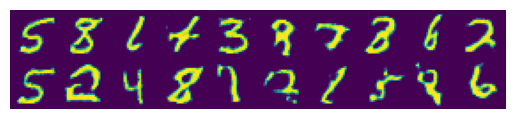

Time since start: 7.87 min
Trained from step 1750 to 1800 in 7.86 steps / sec


Exception ignored in: <generator object Estimator.predict at 0x7c60d32d5f50>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 618, in predict
  File "/usr/lib/python3.10/contextlib.py", line 153, in __exit__
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 5931, in get_controller
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/context.py", line 272, in pop
IndexError: pop from empty list


Average discriminator output on Real: 3.37  Fake: 3.11
Inception Score: 7.11 / 8.35  Frechet Distance: 60.73


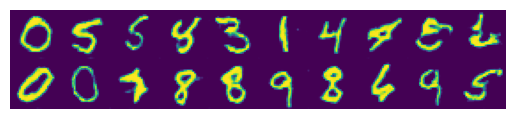

Time since start: 8.11 min
Trained from step 1800 to 1850 in 8.15 steps / sec


Exception ignored in: <generator object Estimator.predict at 0x7c60d2a00f90>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 618, in predict
  File "/usr/lib/python3.10/contextlib.py", line 153, in __exit__
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 5931, in get_controller
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/context.py", line 272, in pop
IndexError: pop from empty list


Average discriminator output on Real: 3.88  Fake: 3.51
Inception Score: 7.18 / 8.35  Frechet Distance: 55.48


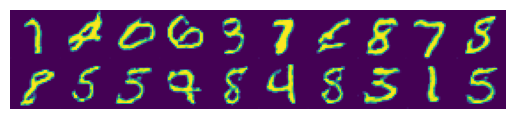

Time since start: 8.31 min
Trained from step 1850 to 1900 in 7.46 steps / sec


Exception ignored in: <generator object Estimator.predict at 0x7c60d3a42810>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 618, in predict
  File "/usr/lib/python3.10/contextlib.py", line 153, in __exit__
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 5931, in get_controller
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/context.py", line 272, in pop
IndexError: pop from empty list


Average discriminator output on Real: 2.51  Fake: 2.34
Inception Score: 7.04 / 8.35  Frechet Distance: 58.58


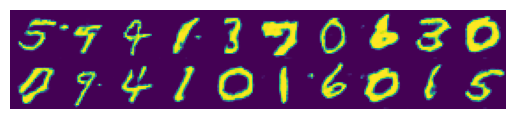

Time since start: 8.51 min
Trained from step 1900 to 1950 in 7.99 steps / sec


Exception ignored in: <generator object Estimator.predict at 0x7c60d8ad4dd0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 618, in predict
  File "/usr/lib/python3.10/contextlib.py", line 153, in __exit__
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 5931, in get_controller
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/context.py", line 272, in pop
IndexError: pop from empty list


Average discriminator output on Real: 3.63  Fake: 3.07
Inception Score: 6.93 / 8.35  Frechet Distance: 61.04


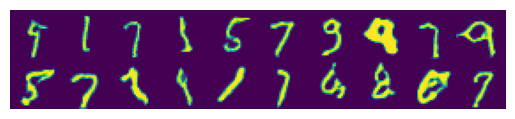

Time since start: 8.71 min
Trained from step 1950 to 2000 in 7.87 steps / sec


Exception ignored in: <generator object Estimator.predict at 0x7c60d29544a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 618, in predict
  File "/usr/lib/python3.10/contextlib.py", line 153, in __exit__
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 5931, in get_controller
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/context.py", line 272, in pop
IndexError: pop from empty list


Average discriminator output on Real: 2.38  Fake: 2.05
Inception Score: 7.30 / 8.35  Frechet Distance: 59.40


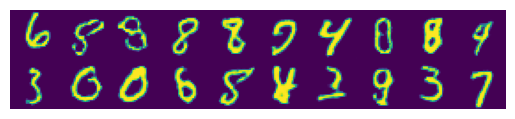

Time since start: 8.94 min
Trained from step 2000 to 2050 in 5.79 steps / sec


Exception ignored in: <generator object Estimator.predict at 0x7c60d20d2ab0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 618, in predict
  File "/usr/lib/python3.10/contextlib.py", line 153, in __exit__
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 5931, in get_controller
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/context.py", line 272, in pop
IndexError: pop from empty list


Average discriminator output on Real: 4.22  Fake: 3.95
Inception Score: 7.27 / 8.35  Frechet Distance: 59.97


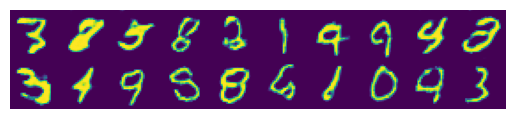

Time since start: 9.15 min
Trained from step 2050 to 2100 in 8.15 steps / sec


Exception ignored in: <generator object Estimator.predict at 0x7c60d0a29e70>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 618, in predict
  File "/usr/lib/python3.10/contextlib.py", line 153, in __exit__
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 5931, in get_controller
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/context.py", line 272, in pop
IndexError: pop from empty list


Average discriminator output on Real: 4.08  Fake: 3.69
Inception Score: 7.15 / 8.35  Frechet Distance: 71.17


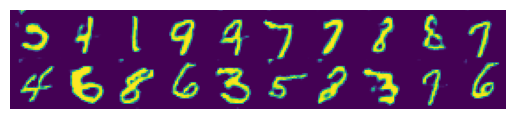

Time since start: 9.36 min
Trained from step 2100 to 2150 in 8.17 steps / sec
Average discriminator output on Real: 3.55  Fake: 3.72
Inception Score: 7.48 / 8.35  Frechet Distance: 55.93


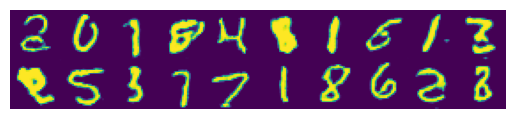

Time since start: 9.59 min
Trained from step 2150 to 2200 in 9.34 steps / sec


Exception ignored in: <generator object Estimator.predict at 0x7c60cdbd7d80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 618, in predict
  File "/usr/lib/python3.10/contextlib.py", line 153, in __exit__
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 5931, in get_controller
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/context.py", line 272, in pop
IndexError: pop from empty list
Exception ignored in: <generator object Estimator.predict at 0x7c60cf9f5c40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 618, in predict
  File "/usr/lib/python3.10/contextlib.py", line 153, in __exit__
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 5931, in get_controller
  File "/usr/local/lib/python3.10/dist

Average discriminator output on Real: 0.56  Fake: 0.35
Inception Score: 7.32 / 8.35  Frechet Distance: 60.63


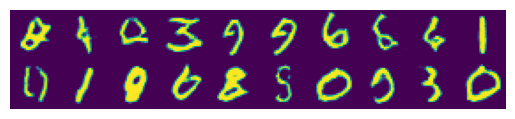

Time since start: 9.82 min
Trained from step 2200 to 2250 in 9.29 steps / sec


Exception ignored in: <generator object Estimator.predict at 0x7c60cd9a3ed0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 618, in predict
  File "/usr/lib/python3.10/contextlib.py", line 153, in __exit__
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 5931, in get_controller
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/context.py", line 272, in pop
IndexError: pop from empty list


Average discriminator output on Real: -0.67  Fake: -1.29
Inception Score: 7.29 / 8.35  Frechet Distance: 58.19


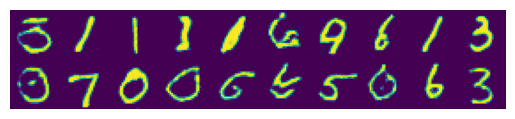

Time since start: 10.02 min
Trained from step 2250 to 2300 in 9.27 steps / sec
Average discriminator output on Real: 1.18  Fake: 0.54
Inception Score: 7.40 / 8.35  Frechet Distance: 58.10


Exception ignored in: <generator object Estimator.predict at 0x7c60d18cd620>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 618, in predict
  File "/usr/lib/python3.10/contextlib.py", line 153, in __exit__
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 5931, in get_controller
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/context.py", line 272, in pop
IndexError: pop from empty list


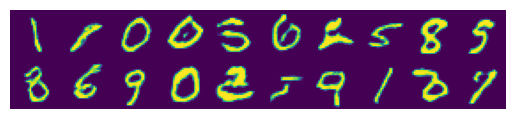

Time since start: 10.22 min
Trained from step 2300 to 2350 in 9.24 steps / sec


Exception ignored in: <generator object Estimator.predict at 0x7c60cb528a50>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 618, in predict
  File "/usr/lib/python3.10/contextlib.py", line 153, in __exit__
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 5931, in get_controller
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/context.py", line 272, in pop
IndexError: pop from empty list


Average discriminator output on Real: 2.34  Fake: 1.22
Inception Score: 7.29 / 8.35  Frechet Distance: 55.11


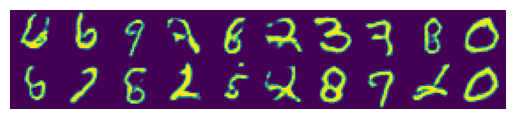

Time since start: 10.43 min
Trained from step 2350 to 2400 in 9.34 steps / sec


Exception ignored in: <generator object Estimator.predict at 0x7c60d06d34c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 618, in predict
  File "/usr/lib/python3.10/contextlib.py", line 153, in __exit__
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 5931, in get_controller
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/context.py", line 272, in pop
IndexError: pop from empty list


Average discriminator output on Real: 0.43  Fake: 0.04
Inception Score: 7.36 / 8.35  Frechet Distance: 59.72


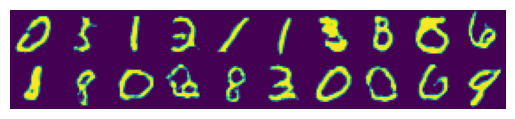

Time since start: 10.65 min
Trained from step 2400 to 2450 in 7.94 steps / sec


Exception ignored in: <generator object Estimator.predict at 0x7c60cc450190>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 618, in predict
  File "/usr/lib/python3.10/contextlib.py", line 153, in __exit__
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 5931, in get_controller
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/context.py", line 272, in pop
IndexError: pop from empty list


Average discriminator output on Real: -1.03  Fake: -1.65
Inception Score: 7.34 / 8.35  Frechet Distance: 58.20


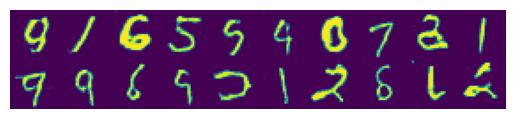

Time since start: 10.84 min
Trained from step 2450 to 2500 in 9.44 steps / sec


Exception ignored in: <generator object Estimator.predict at 0x7c60d0022ea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 618, in predict
  File "/usr/lib/python3.10/contextlib.py", line 153, in __exit__
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 5931, in get_controller
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/context.py", line 272, in pop
IndexError: pop from empty list


Average discriminator output on Real: 2.21  Fake: 1.27
Inception Score: 7.32 / 8.35  Frechet Distance: 59.69


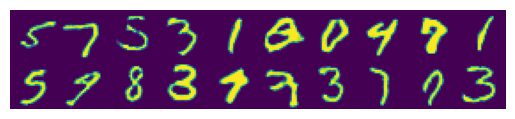

Time since start: 11.03 min
Trained from step 2500 to 2550 in 9.42 steps / sec
Average discriminator output on Real: -6.36  Fake: -6.65
Inception Score: 7.30 / 8.35  Frechet Distance: 64.00


Exception ignored in: <generator object Estimator.predict at 0x7c60cc8c1690>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 618, in predict
  File "/usr/lib/python3.10/contextlib.py", line 153, in __exit__
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 5931, in get_controller
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/context.py", line 272, in pop
IndexError: pop from empty list


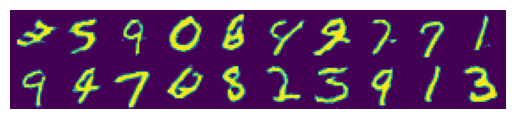

Time since start: 11.24 min
Trained from step 2550 to 2600 in 9.51 steps / sec


Exception ignored in: <generator object Estimator.predict at 0x7c60cefbb610>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 618, in predict
  File "/usr/lib/python3.10/contextlib.py", line 153, in __exit__
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 5931, in get_controller
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/context.py", line 272, in pop
IndexError: pop from empty list


Average discriminator output on Real: -0.90  Fake: -1.58
Inception Score: 7.21 / 8.35  Frechet Distance: 67.98


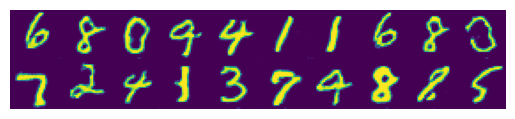

Time since start: 11.45 min
Trained from step 2600 to 2650 in 9.41 steps / sec


Exception ignored in: <generator object Estimator.predict at 0x7c60ccfcfb50>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 618, in predict
  File "/usr/lib/python3.10/contextlib.py", line 153, in __exit__
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 5931, in get_controller
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/context.py", line 272, in pop
IndexError: pop from empty list


Average discriminator output on Real: -1.64  Fake: -2.33
Inception Score: 7.34 / 8.35  Frechet Distance: 64.39


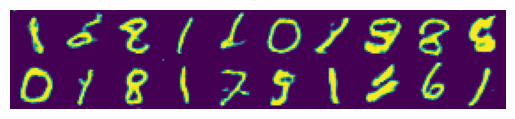

Time since start: 11.70 min
Trained from step 2650 to 2700 in 7.27 steps / sec


Exception ignored in: <generator object Estimator.predict at 0x7c60cbbffe60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 618, in predict
  File "/usr/lib/python3.10/contextlib.py", line 153, in __exit__
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 5931, in get_controller
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/context.py", line 272, in pop
IndexError: pop from empty list


Average discriminator output on Real: 1.64  Fake: -0.21
Inception Score: 7.33 / 8.35  Frechet Distance: 58.15


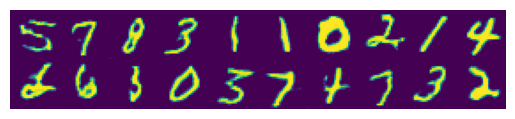

Time since start: 11.89 min
Trained from step 2700 to 2750 in 9.31 steps / sec


Exception ignored in: <generator object Estimator.predict at 0x7c60c9877ae0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 618, in predict
  File "/usr/lib/python3.10/contextlib.py", line 153, in __exit__
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 5931, in get_controller
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/context.py", line 272, in pop
IndexError: pop from empty list


Average discriminator output on Real: -0.45  Fake: -1.14
Inception Score: 7.36 / 8.35  Frechet Distance: 60.17


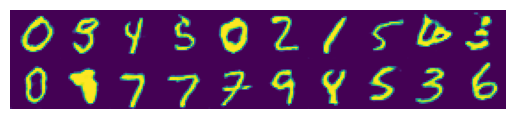

Time since start: 12.08 min
Trained from step 2750 to 2800 in 9.43 steps / sec


Exception ignored in: <generator object Estimator.predict at 0x7c60d02c35a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 618, in predict
  File "/usr/lib/python3.10/contextlib.py", line 153, in __exit__
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 5931, in get_controller
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/context.py", line 272, in pop
IndexError: pop from empty list


Average discriminator output on Real: 2.41  Fake: 1.62
Inception Score: 7.37 / 8.35  Frechet Distance: 66.99


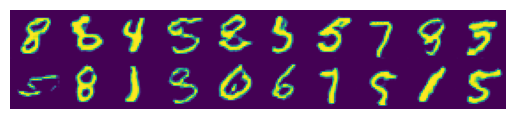

Time since start: 12.27 min
Trained from step 2800 to 2850 in 9.43 steps / sec


Exception ignored in: <generator object Estimator.predict at 0x7c60d97efae0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 618, in predict
  File "/usr/lib/python3.10/contextlib.py", line 153, in __exit__
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 5931, in get_controller
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/context.py", line 272, in pop
IndexError: pop from empty list


Average discriminator output on Real: -0.10  Fake: -2.12
Inception Score: 7.52 / 8.35  Frechet Distance: 54.62


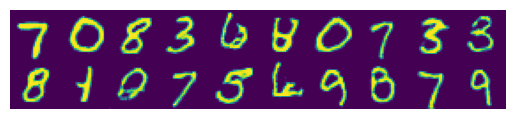

Time since start: 12.47 min
Trained from step 2850 to 2900 in 9.54 steps / sec


Exception ignored in: <generator object Estimator.predict at 0x7c60cad99540>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 618, in predict
  File "/usr/lib/python3.10/contextlib.py", line 153, in __exit__
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 5931, in get_controller
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/context.py", line 272, in pop
IndexError: pop from empty list


Average discriminator output on Real: -0.51  Fake: -2.00
Inception Score: 7.41 / 8.35  Frechet Distance: 56.65


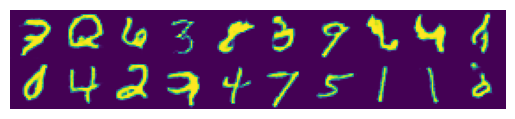

Time since start: 12.67 min
Trained from step 2900 to 2950 in 9.62 steps / sec


Exception ignored in: <generator object Estimator.predict at 0x7c60c9ccb6f0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 618, in predict
  File "/usr/lib/python3.10/contextlib.py", line 153, in __exit__
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 5931, in get_controller
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/context.py", line 272, in pop
IndexError: pop from empty list


Average discriminator output on Real: 4.38  Fake: 3.85
Inception Score: 7.44 / 8.35  Frechet Distance: 60.85


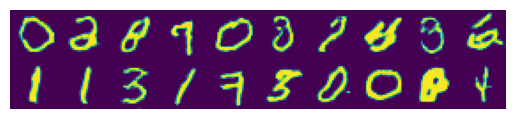

Time since start: 12.88 min
Trained from step 2950 to 3000 in 9.51 steps / sec


Exception ignored in: <generator object Estimator.predict at 0x7c60ca595f50>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 618, in predict
  File "/usr/lib/python3.10/contextlib.py", line 153, in __exit__
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 5931, in get_controller
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/context.py", line 272, in pop
IndexError: pop from empty list


Average discriminator output on Real: 2.91  Fake: 0.66
Inception Score: 7.28 / 8.35  Frechet Distance: 60.89


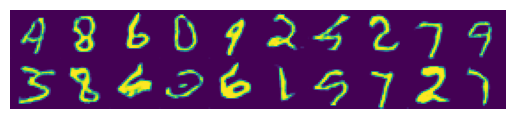

Time since start: 13.08 min
Trained from step 3000 to 3050 in 9.40 steps / sec


Exception ignored in: <generator object Estimator.predict at 0x7c60c7e7ab20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 618, in predict
  File "/usr/lib/python3.10/contextlib.py", line 153, in __exit__
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 5931, in get_controller
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/context.py", line 272, in pop
IndexError: pop from empty list


Average discriminator output on Real: -5.96  Fake: -7.31
Inception Score: 7.38 / 8.35  Frechet Distance: 62.10


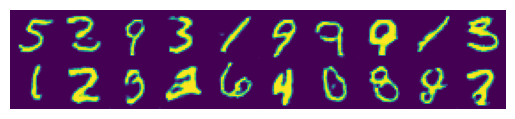

Time since start: 13.28 min
Trained from step 3050 to 3100 in 9.45 steps / sec


Exception ignored in: <generator object Estimator.predict at 0x7c60c8be6810>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 618, in predict
  File "/usr/lib/python3.10/contextlib.py", line 153, in __exit__
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 5931, in get_controller
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/context.py", line 272, in pop
IndexError: pop from empty list


Average discriminator output on Real: -0.83  Fake: -2.19
Inception Score: 7.41 / 8.35  Frechet Distance: 61.56


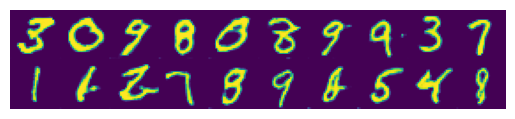

Time since start: 13.49 min
Trained from step 3100 to 3150 in 9.22 steps / sec


Exception ignored in: <generator object Estimator.predict at 0x7c60c858f0d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 618, in predict
  File "/usr/lib/python3.10/contextlib.py", line 153, in __exit__
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 5931, in get_controller
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/context.py", line 272, in pop
IndexError: pop from empty list


Average discriminator output on Real: 0.33  Fake: -2.14
Inception Score: 7.45 / 8.35  Frechet Distance: 55.31


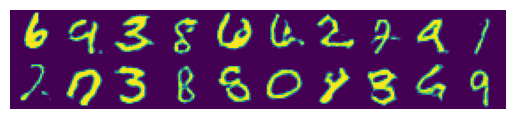

Time since start: 13.70 min
Trained from step 3150 to 3200 in 9.35 steps / sec


Exception ignored in: <generator object Estimator.predict at 0x7c60c7229850>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 618, in predict
  File "/usr/lib/python3.10/contextlib.py", line 153, in __exit__
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 5931, in get_controller
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/context.py", line 272, in pop
IndexError: pop from empty list


Average discriminator output on Real: 0.25  Fake: -0.89
Inception Score: 7.29 / 8.35  Frechet Distance: 61.80


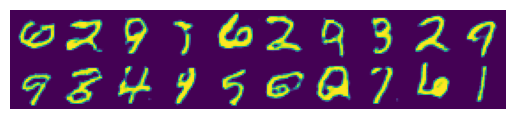

Time since start: 13.94 min
Trained from step 3200 to 3250 in 9.37 steps / sec


Exception ignored in: <generator object Estimator.predict at 0x7c60c6bf7e60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 618, in predict
  File "/usr/lib/python3.10/contextlib.py", line 153, in __exit__
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 5931, in get_controller
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/context.py", line 272, in pop
IndexError: pop from empty list


Average discriminator output on Real: 1.10  Fake: -0.83
Inception Score: 7.42 / 8.35  Frechet Distance: 57.58


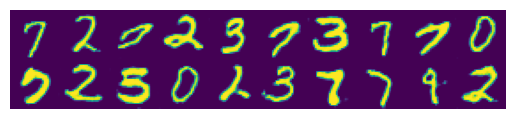

Time since start: 14.13 min
Trained from step 3250 to 3300 in 9.28 steps / sec


Exception ignored in: <generator object Estimator.predict at 0x7c60c4de8dd0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 618, in predict
  File "/usr/lib/python3.10/contextlib.py", line 153, in __exit__
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 5931, in get_controller
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/context.py", line 272, in pop
IndexError: pop from empty list


Average discriminator output on Real: 4.64  Fake: 2.72
Inception Score: 7.51 / 8.35  Frechet Distance: 59.28


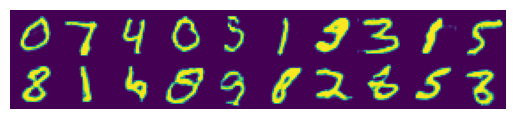

Time since start: 14.32 min
Trained from step 3300 to 3350 in 9.37 steps / sec


Exception ignored in: <generator object Estimator.predict at 0x7c60d0af70d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 618, in predict
  File "/usr/lib/python3.10/contextlib.py", line 153, in __exit__
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 5931, in get_controller
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/context.py", line 272, in pop
IndexError: pop from empty list


Average discriminator output on Real: 2.03  Fake: 0.60
Inception Score: 7.51 / 8.35  Frechet Distance: 59.12


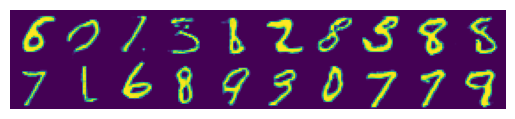

Time since start: 14.53 min
Trained from step 3350 to 3400 in 9.47 steps / sec


Exception ignored in: <generator object Estimator.predict at 0x7c60c946c890>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 618, in predict
  File "/usr/lib/python3.10/contextlib.py", line 153, in __exit__
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 5931, in get_controller
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/context.py", line 272, in pop
IndexError: pop from empty list


Average discriminator output on Real: 1.56  Fake: -2.49
Inception Score: 7.47 / 8.35  Frechet Distance: 56.72


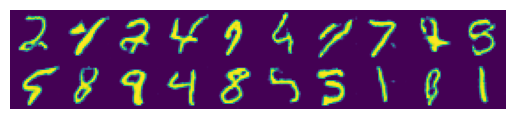

Time since start: 14.73 min
Trained from step 3400 to 3450 in 9.30 steps / sec


Exception ignored in: <generator object Estimator.predict at 0x7c60c4a4bf40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 618, in predict
  File "/usr/lib/python3.10/contextlib.py", line 153, in __exit__
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 5931, in get_controller
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/context.py", line 272, in pop
IndexError: pop from empty list


Average discriminator output on Real: 4.10  Fake: 2.55
Inception Score: 7.50 / 8.35  Frechet Distance: 55.81


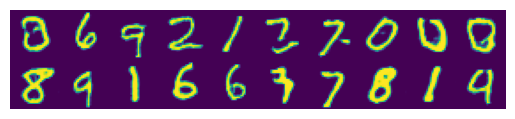

Time since start: 14.93 min
Trained from step 3450 to 3500 in 9.51 steps / sec


Exception ignored in: <generator object Estimator.predict at 0x7c60c59b2730>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 618, in predict
  File "/usr/lib/python3.10/contextlib.py", line 153, in __exit__
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 5931, in get_controller
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/context.py", line 272, in pop
IndexError: pop from empty list


Average discriminator output on Real: 11.23  Fake: 9.45
Inception Score: 7.35 / 8.35  Frechet Distance: 54.73


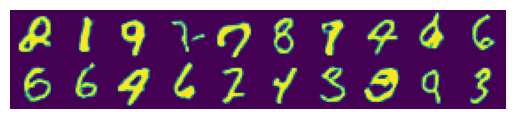

Time since start: 15.13 min
Trained from step 3500 to 3550 in 9.37 steps / sec


Exception ignored in: <generator object Estimator.predict at 0x7c60b1f95460>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 618, in predict
  File "/usr/lib/python3.10/contextlib.py", line 153, in __exit__
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 5931, in get_controller
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/context.py", line 272, in pop
IndexError: pop from empty list


Average discriminator output on Real: 28.46  Fake: 27.30
Inception Score: 7.24 / 8.35  Frechet Distance: 63.87


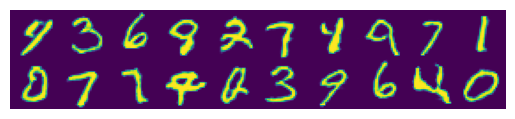

Time since start: 15.33 min
Trained from step 3550 to 3600 in 9.48 steps / sec


Exception ignored in: <generator object Estimator.predict at 0x7c60c3e1bf40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 618, in predict
  File "/usr/lib/python3.10/contextlib.py", line 153, in __exit__
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 5931, in get_controller
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/context.py", line 272, in pop
IndexError: pop from empty list


Average discriminator output on Real: 26.62  Fake: 23.58
Inception Score: 7.36 / 8.35  Frechet Distance: 59.06


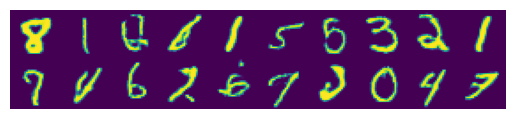

Time since start: 15.53 min
Trained from step 3600 to 3650 in 9.33 steps / sec


Exception ignored in: <generator object Estimator.predict at 0x7c60c36a19a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 618, in predict
  File "/usr/lib/python3.10/contextlib.py", line 153, in __exit__
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 5931, in get_controller
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/context.py", line 272, in pop
IndexError: pop from empty list


Average discriminator output on Real: 39.77  Fake: 36.12
Inception Score: 7.44 / 8.35  Frechet Distance: 57.80


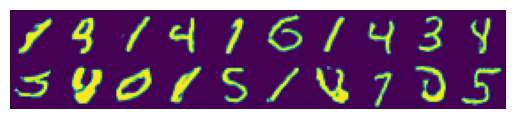

Time since start: 15.74 min
Trained from step 3650 to 3700 in 9.24 steps / sec


Exception ignored in: <generator object Estimator.predict at 0x7c60c035bed0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 618, in predict
  File "/usr/lib/python3.10/contextlib.py", line 153, in __exit__
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 5931, in get_controller
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/context.py", line 272, in pop
IndexError: pop from empty list


Average discriminator output on Real: 32.48  Fake: 29.28
Inception Score: 7.60 / 8.35  Frechet Distance: 60.70


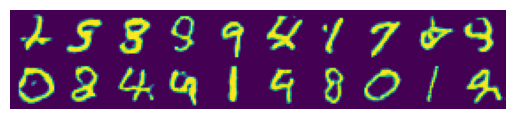

Time since start: 15.95 min
Trained from step 3700 to 3750 in 9.40 steps / sec


Exception ignored in: <generator object Estimator.predict at 0x7c60b1797370>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 618, in predict
  File "/usr/lib/python3.10/contextlib.py", line 153, in __exit__
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 5931, in get_controller
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/context.py", line 272, in pop
IndexError: pop from empty list


Average discriminator output on Real: 35.15  Fake: 31.45
Inception Score: 7.63 / 8.35  Frechet Distance: 56.82


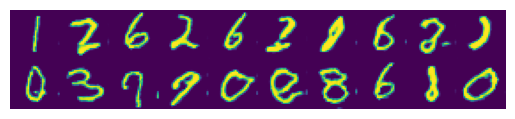

Time since start: 16.17 min
Trained from step 3750 to 3800 in 9.34 steps / sec


Exception ignored in: <generator object Estimator.predict at 0x7c60b0f80120>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 618, in predict
  File "/usr/lib/python3.10/contextlib.py", line 153, in __exit__
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 5931, in get_controller
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/context.py", line 272, in pop
IndexError: pop from empty list


Average discriminator output on Real: 38.46  Fake: 35.48
Inception Score: 7.35 / 8.35  Frechet Distance: 64.31


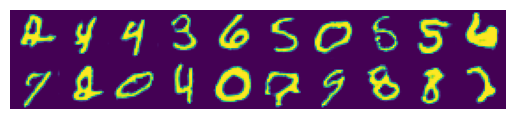

Time since start: 16.45 min
Trained from step 3800 to 3850 in 4.90 steps / sec


Exception ignored in: <generator object Estimator.predict at 0x7c60b0bb9770>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 618, in predict
  File "/usr/lib/python3.10/contextlib.py", line 153, in __exit__
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 5931, in get_controller
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/context.py", line 272, in pop
IndexError: pop from empty list


Average discriminator output on Real: 52.65  Fake: 50.73
Inception Score: 7.34 / 8.35  Frechet Distance: 60.39


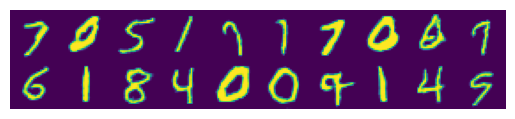

Time since start: 16.69 min
Trained from step 3850 to 3900 in 5.85 steps / sec


Exception ignored in: <generator object Estimator.predict at 0x7c60b02d4660>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 618, in predict
  File "/usr/lib/python3.10/contextlib.py", line 153, in __exit__
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 5931, in get_controller
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/context.py", line 272, in pop
IndexError: pop from empty list


Average discriminator output on Real: 54.24  Fake: 46.99
Inception Score: 7.37 / 8.35  Frechet Distance: 59.94


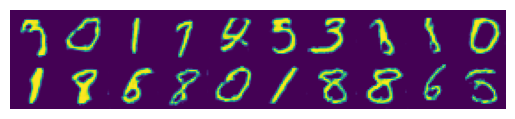

Time since start: 16.92 min
Trained from step 3900 to 3950 in 6.18 steps / sec


Exception ignored in: <generator object Estimator.predict at 0x7c60c5082ea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 618, in predict
  File "/usr/lib/python3.10/contextlib.py", line 153, in __exit__
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 5931, in get_controller
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/context.py", line 272, in pop
IndexError: pop from empty list


Average discriminator output on Real: 43.17  Fake: 40.52
Inception Score: 7.56 / 8.35  Frechet Distance: 61.91


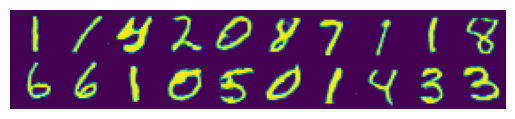

Time since start: 17.12 min
Trained from step 3950 to 4000 in 7.99 steps / sec


Exception ignored in: <generator object Estimator.predict at 0x7c60cda04f20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 618, in predict
  File "/usr/lib/python3.10/contextlib.py", line 153, in __exit__
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 5931, in get_controller
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/context.py", line 272, in pop
IndexError: pop from empty list


Average discriminator output on Real: 51.25  Fake: 50.09
Inception Score: 7.40 / 8.35  Frechet Distance: 59.78


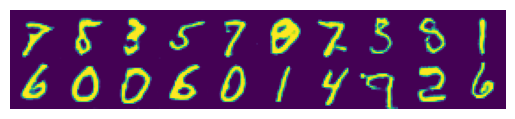

Time since start: 17.32 min
Trained from step 4000 to 4050 in 7.76 steps / sec


Exception ignored in: <generator object Estimator.predict at 0x7c60c3acc0b0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 618, in predict
  File "/usr/lib/python3.10/contextlib.py", line 153, in __exit__
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 5931, in get_controller
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/context.py", line 272, in pop
IndexError: pop from empty list


Average discriminator output on Real: 37.58  Fake: 35.76
Inception Score: 7.59 / 8.35  Frechet Distance: 55.08


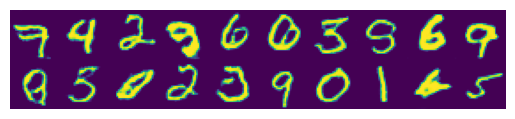

Time since start: 17.52 min
Trained from step 4050 to 4100 in 7.79 steps / sec


Exception ignored in: <generator object Estimator.predict at 0x7c60b81d1d90>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 618, in predict
  File "/usr/lib/python3.10/contextlib.py", line 153, in __exit__
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 5931, in get_controller
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/context.py", line 272, in pop
IndexError: pop from empty list


Average discriminator output on Real: 41.61  Fake: 39.11
Inception Score: 7.53 / 8.35  Frechet Distance: 58.76


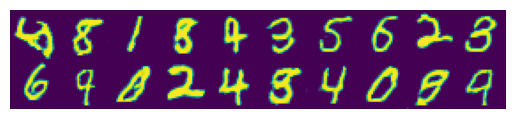

Time since start: 17.74 min
Trained from step 4100 to 4150 in 6.32 steps / sec


Exception ignored in: <generator object Estimator.predict at 0x7c60a89790e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 618, in predict
  File "/usr/lib/python3.10/contextlib.py", line 153, in __exit__
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 5931, in get_controller
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/context.py", line 272, in pop
IndexError: pop from empty list


Average discriminator output on Real: 47.64  Fake: 45.54
Inception Score: 7.50 / 8.35  Frechet Distance: 56.78


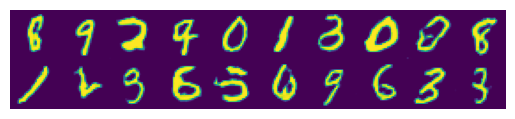

Time since start: 17.94 min
Trained from step 4150 to 4200 in 7.89 steps / sec


Exception ignored in: <generator object Estimator.predict at 0x7c60a8d89d90>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 618, in predict
  File "/usr/lib/python3.10/contextlib.py", line 153, in __exit__
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 5931, in get_controller
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/context.py", line 272, in pop
IndexError: pop from empty list


Average discriminator output on Real: 79.37  Fake: 73.33
Inception Score: 7.44 / 8.35  Frechet Distance: 55.98


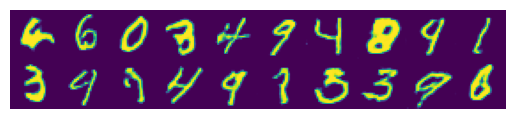

Time since start: 18.13 min
Trained from step 4200 to 4250 in 7.91 steps / sec


Exception ignored in: <generator object Estimator.predict at 0x7c60a827fb50>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 618, in predict
  File "/usr/lib/python3.10/contextlib.py", line 153, in __exit__
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 5931, in get_controller
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/context.py", line 272, in pop
IndexError: pop from empty list


Average discriminator output on Real: 102.15  Fake: 95.15
Inception Score: 7.44 / 8.35  Frechet Distance: 57.30


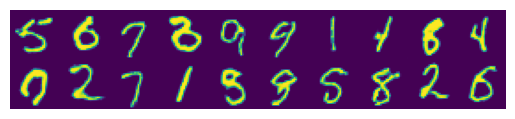

Time since start: 18.34 min
Trained from step 4250 to 4300 in 7.58 steps / sec


Exception ignored in: <generator object Estimator.predict at 0x7c609d2eb3e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 618, in predict
  File "/usr/lib/python3.10/contextlib.py", line 153, in __exit__
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 5931, in get_controller
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/context.py", line 272, in pop
IndexError: pop from empty list


Average discriminator output on Real: 92.16  Fake: 88.24
Inception Score: 7.50 / 8.35  Frechet Distance: 59.63


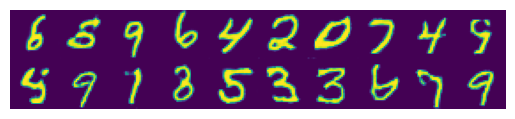

Time since start: 18.57 min
Trained from step 4300 to 4350 in 6.34 steps / sec


Exception ignored in: <generator object Estimator.predict at 0x7c609da05690>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 618, in predict
  File "/usr/lib/python3.10/contextlib.py", line 153, in __exit__
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 5931, in get_controller
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/context.py", line 272, in pop
IndexError: pop from empty list


Average discriminator output on Real: 106.67  Fake: 102.27
Inception Score: 7.54 / 8.35  Frechet Distance: 58.50


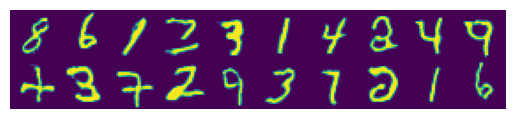

Time since start: 18.77 min
Trained from step 4350 to 4400 in 7.73 steps / sec
Average discriminator output on Real: 97.63  Fake: 95.76
Inception Score: 7.54 / 8.35  Frechet Distance: 57.25


Exception ignored in: <generator object Estimator.predict at 0x7c60952bbe60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 618, in predict
  File "/usr/lib/python3.10/contextlib.py", line 153, in __exit__
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 5931, in get_controller
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/context.py", line 272, in pop
IndexError: pop from empty list


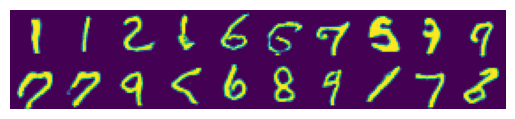

Time since start: 18.96 min
Trained from step 4400 to 4450 in 7.89 steps / sec


Exception ignored in: <generator object Estimator.predict at 0x7c609c94f0d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 618, in predict
  File "/usr/lib/python3.10/contextlib.py", line 153, in __exit__
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 5931, in get_controller
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/context.py", line 272, in pop
IndexError: pop from empty list


Average discriminator output on Real: 79.79  Fake: 75.96
Inception Score: 7.39 / 8.35  Frechet Distance: 59.21


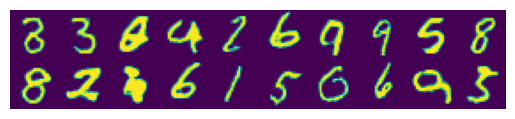

Time since start: 19.18 min
Trained from step 4450 to 4500 in 7.83 steps / sec


Exception ignored in: <generator object Estimator.predict at 0x7c609582d620>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 618, in predict
  File "/usr/lib/python3.10/contextlib.py", line 153, in __exit__
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 5931, in get_controller
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/context.py", line 272, in pop
IndexError: pop from empty list


Average discriminator output on Real: 56.19  Fake: 52.16
Inception Score: 7.41 / 8.35  Frechet Distance: 57.31


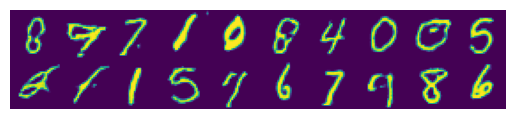

Time since start: 19.40 min
Trained from step 4500 to 4550 in 7.83 steps / sec


Exception ignored in: <generator object Estimator.predict at 0x7c6094a5b990>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 618, in predict
  File "/usr/lib/python3.10/contextlib.py", line 153, in __exit__
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 5931, in get_controller
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/context.py", line 272, in pop
IndexError: pop from empty list


Average discriminator output on Real: 62.44  Fake: 58.21
Inception Score: 7.46 / 8.35  Frechet Distance: 56.37


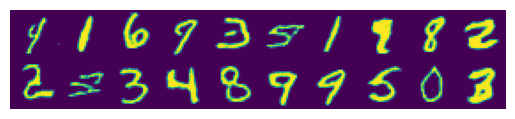

Time since start: 19.69 min
Trained from step 4550 to 4600 in 5.89 steps / sec


Exception ignored in: <generator object Estimator.predict at 0x7c60860e35a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 618, in predict
  File "/usr/lib/python3.10/contextlib.py", line 153, in __exit__
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 5931, in get_controller
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/context.py", line 272, in pop
IndexError: pop from empty list


Average discriminator output on Real: 60.32  Fake: 55.56
Inception Score: 7.45 / 8.35  Frechet Distance: 55.74


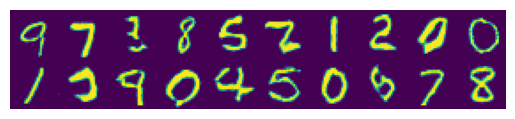

Time since start: 19.89 min
Trained from step 4600 to 4650 in 8.50 steps / sec


Exception ignored in: <generator object Estimator.predict at 0x7c609d861620>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 618, in predict
  File "/usr/lib/python3.10/contextlib.py", line 153, in __exit__
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 5931, in get_controller
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/context.py", line 272, in pop
IndexError: pop from empty list


Average discriminator output on Real: 55.71  Fake: 52.79
Inception Score: 7.62 / 8.35  Frechet Distance: 59.98


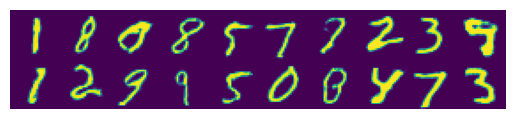

Time since start: 20.10 min
Trained from step 4650 to 4700 in 9.03 steps / sec


Exception ignored in: <generator object Estimator.predict at 0x7c60a89f4a50>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 618, in predict
  File "/usr/lib/python3.10/contextlib.py", line 153, in __exit__
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 5931, in get_controller
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/context.py", line 272, in pop
IndexError: pop from empty list


Average discriminator output on Real: 71.67  Fake: 66.85
Inception Score: 7.54 / 8.35  Frechet Distance: 58.62


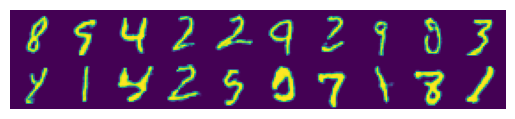

Time since start: 20.30 min
Trained from step 4700 to 4750 in 9.09 steps / sec


Exception ignored in: <generator object Estimator.predict at 0x7c60957eb8b0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 618, in predict
  File "/usr/lib/python3.10/contextlib.py", line 153, in __exit__
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 5931, in get_controller
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/context.py", line 272, in pop
IndexError: pop from empty list


Average discriminator output on Real: 64.26  Fake: 61.32
Inception Score: 7.27 / 8.35  Frechet Distance: 64.29


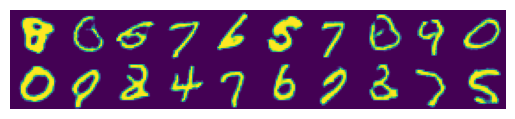

Time since start: 20.51 min
Trained from step 4750 to 4800 in 8.72 steps / sec


Exception ignored in: <generator object Estimator.predict at 0x7c6094858270>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 618, in predict
  File "/usr/lib/python3.10/contextlib.py", line 153, in __exit__
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 5931, in get_controller
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/context.py", line 272, in pop
IndexError: pop from empty list


Average discriminator output on Real: 41.00  Fake: 36.23
Inception Score: 7.25 / 8.35  Frechet Distance: 59.86


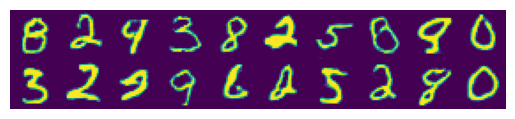

Time since start: 20.72 min
Trained from step 4800 to 4850 in 8.97 steps / sec


Exception ignored in: <generator object Estimator.predict at 0x7c6084137920>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 618, in predict
  File "/usr/lib/python3.10/contextlib.py", line 153, in __exit__
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 5931, in get_controller
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/context.py", line 272, in pop
IndexError: pop from empty list


Average discriminator output on Real: 45.03  Fake: 40.46
Inception Score: 7.42 / 8.35  Frechet Distance: 55.10


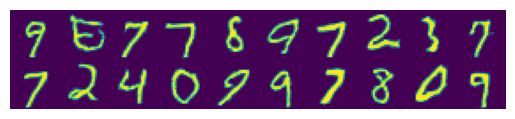

Time since start: 20.93 min
Trained from step 4850 to 4900 in 9.04 steps / sec


Exception ignored in: <generator object Estimator.predict at 0x7c608546ece0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 618, in predict
  File "/usr/lib/python3.10/contextlib.py", line 153, in __exit__
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 5931, in get_controller
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/context.py", line 272, in pop
IndexError: pop from empty list


Average discriminator output on Real: 58.62  Fake: 55.05
Inception Score: 7.38 / 8.35  Frechet Distance: 59.23


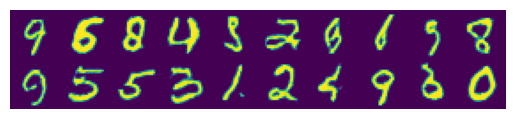

Time since start: 21.13 min
Trained from step 4900 to 4950 in 9.10 steps / sec


Exception ignored in: <generator object Estimator.predict at 0x7c60858b7ed0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 618, in predict
  File "/usr/lib/python3.10/contextlib.py", line 153, in __exit__
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 5931, in get_controller
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/context.py", line 272, in pop
IndexError: pop from empty list


Average discriminator output on Real: 42.47  Fake: 38.09
Inception Score: 7.52 / 8.35  Frechet Distance: 62.07


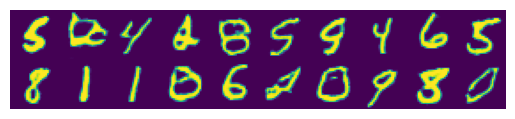

Time since start: 21.34 min
Trained from step 4950 to 5000 in 8.51 steps / sec


Exception ignored in: <generator object Estimator.predict at 0x7c607d9a1620>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 618, in predict
  File "/usr/lib/python3.10/contextlib.py", line 153, in __exit__
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 5931, in get_controller
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/context.py", line 272, in pop
IndexError: pop from empty list


Average discriminator output on Real: 33.12  Fake: 29.57
Inception Score: 7.55 / 8.35  Frechet Distance: 56.87


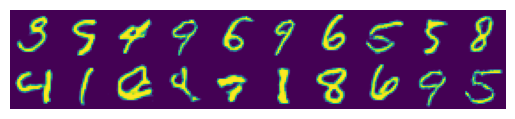

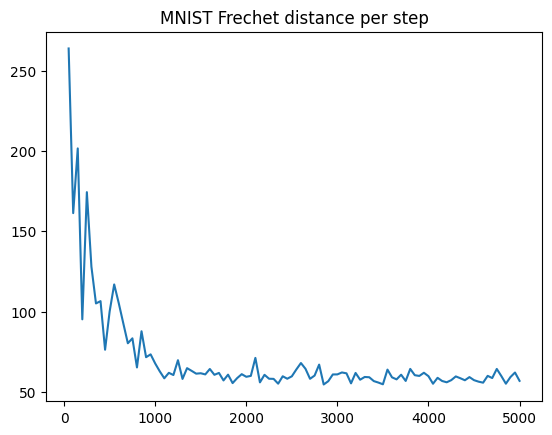

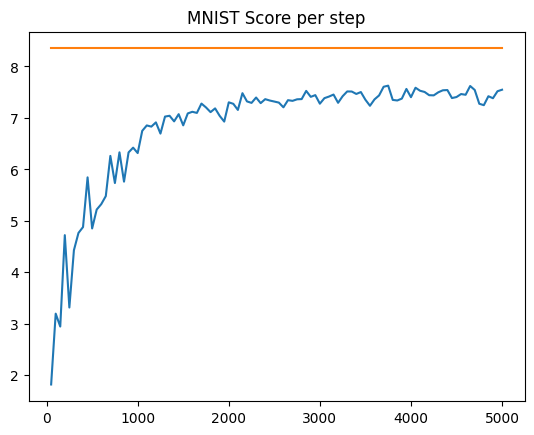

In [14]:
# Training process using GANEstimator
cur_step = 0
start_time = time.time()

while cur_step < max_train_steps:
  next_step = min(cur_step + steps_per_eval, max_train_steps)

  start = time.time()

  gan_estimator.train(input_fun, max_steps=next_step)

  steps_taken = next_step - cur_step
  time_taken = time.time() - start

  print('Time since start: %.2f min' % ((time.time() - start_time) / 60.0))
  print('Trained from step %i to %i in %.2f steps / sec' % (
      cur_step, next_step, steps_taken / time_taken))

  cur_step = next_step

  # Calculate some metrics.
  metrics = gan_estimator.evaluate(input_fun, steps=batches_for_eval_metrics)

  steps.append(cur_step)
  real_logits.append(metrics['real_data_logits'])
  fake_logits.append(metrics['gen_data_logits'])
  real_mnist_scores.append(metrics['real_mnist_score'])
  mnist_scores.append(metrics['mnist_score'])
  frechet_distances.append(metrics['frechet_distance'])

  print('Average discriminator output on Real: %.2f  Fake: %.2f' % (
      real_logits[-1], fake_logits[-1]))
  print('Inception Score: %.2f / %.2f  Frechet Distance: %.2f' % (
      mnist_scores[-1], real_mnist_scores[-1], frechet_distances[-1]))

  # Vizualize some images.
  iterator = gan_estimator.predict(
      input_fun, hooks=[tfv1.train.StopAtStepHook(num_steps=21)])

  try:
    imgs = np.array([next(iterator) for _ in range(20)])
  except StopIteration:
    pass

  tiled = tfgan.eval.python_image_grid(imgs, grid_shape=(2, 10))
  plt.axis('off')
  plt.imshow(np.squeeze(tiled))
  plt.show()


# Plot the metrics vs step.
plt.title('MNIST Frechet distance per step')
plt.plot(steps, frechet_distances)
plt.figure()
plt.title('MNIST Score per step')
plt.plot(steps, mnist_scores)
plt.plot(steps, real_mnist_scores)
plt.show()